In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Load training data

In [2]:
data = pd.read_csv('train.csv', sep=';')

In [3]:
data.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
372313,25/6-2,2269.352000,489836.28125,6602686.5,-2241.471680,CROMER KNOLL GP.,Mime Fm.,12.581059,3.054129,2.510636,...,5818.612793,NaN,NaN,0.038712,0.143792,2.756711,NaN,1.715284,80000,2.0
1153676,7/1-1,554.104800,450396.56250,6406647.5,-520.102173,NORDLAND GP.,NaN,18.069183,1.307377,1.309063,...,0.224774,NaN,0.569183,NaN,1.054472,NaN,NaN,NaN,65000,1.0
462810,26/4-1,2923.952200,501132.25000,6608171.5,-2900.683105,DUNLIN GP.,Drake Fm.,9.095864,4.777131,8.669496,...,5.416234,NaN,0.595864,0.017973,0.143792,NaN,NaN,NaN,65000,1.0
777414,34/10-21,2888.490403,454130.84375,6777267.0,-2859.038330,SHETLAND GP.,Kyrre Fm.,13.344760,0.893483,1.352168,...,NaN,NaN,NaN,0.010415,NaN,NaN,NaN,0.987641,65000,1.0
888544,34/5-1 A,3797.177992,479081.75000,6844708.0,-3231.346191,SHETLAND GP.,Kyrre Fm.,12.050184,NaN,1.600577,...,35.602058,196.17395,NaN,-0.008531,NaN,NaN,25.36585,NaN,65000,1.0
56869,16/1-6 A,1449.275735,459499.12500,6539472.5,-1410.602783,HORDALAND GP.,Skade Fm.,9.126155,NaN,0.648945,...,24.565605,NaN,NaN,NaN,0.173748,NaN,NaN,NaN,65000,1.0
901079,34/7-20,1531.022000,448295.62500,6812831.0,-1504.985718,HORDALAND GP.,Utsira Fm.,17.890642,0.773303,0.564566,...,NaN,NaN,NaN,-0.004461,NaN,NaN,NaN,NaN,65000,1.0
315758,25/4-5,1825.646805,454469.53125,6603730.0,-1800.346924,HORDALAND GP.,Grid Mb.,17.995275,NaN,0.754882,...,NaN,NaN,0.495276,0.018995,NaN,NaN,NaN,NaN,65000,1.0
798844,34/10-35,2272.791000,463384.43750,6771049.0,-2249.611572,SHETLAND GP.,Vaale Fm.,21.020674,NaN,1.223856,...,NaN,NaN,NaN,0.106082,NaN,NaN,NaN,NaN,65030,1.0
417552,25/8-5 S,2490.934400,464010.43750,6590901.0,-2341.356445,ROGALAND GP.,Lista Fm.,10.545247,1.418912,1.327446,...,2.945843,NaN,2.045248,0.007004,1.222229,NaN,NaN,1.120564,65000,1.0


In [4]:
data.shape

(1170511, 29)

In [5]:
data.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

### Inspecting available logs and interpretations

The data contains the metadata columns
* WELL: well name
* DEPTH_MD: measured depth
* X_LOC: UTM X coordinate 
* Y_LOC: UTM Y coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves. For example the following:
* BS: Bit Size
* CALI: Caliper
* RDEP: Deep Resistivity
* RHOB: Bulk Density
* GR: Raw gamma data
* SGR: Spectral Gamma Ray
* RMED: Medium Resistivity
* ROP: Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RSHA: Shallow Resistivity
* DTS: Sonic (Sheer Slowness)
* DTC: Sonic (Compressional Slowness)

See contest page for full list.

as well as the interpretation

* FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label
* FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation (1: high, 2: medium, 3: low)

There is a total of 83 wells in the training dataset. The `WELL` column is included so the data can be separated per well. This will be necessary for any "windowed" approaches where we use non-local information in the ML features. 

In [6]:
wells = data['WELL'].unique()

In [7]:
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

### The LITHOLOGY column

The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [10]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [11]:
data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()

array([65000, 30000, 65030, 70000, 99000, 80000, 86000, 74000, 70032,
       90000, 88000, 93000], dtype=int64)

Lithologies are not equally likely. This is reflected in this dataset.

Text(0, 0.5, 'Lithology presence (\\%)')

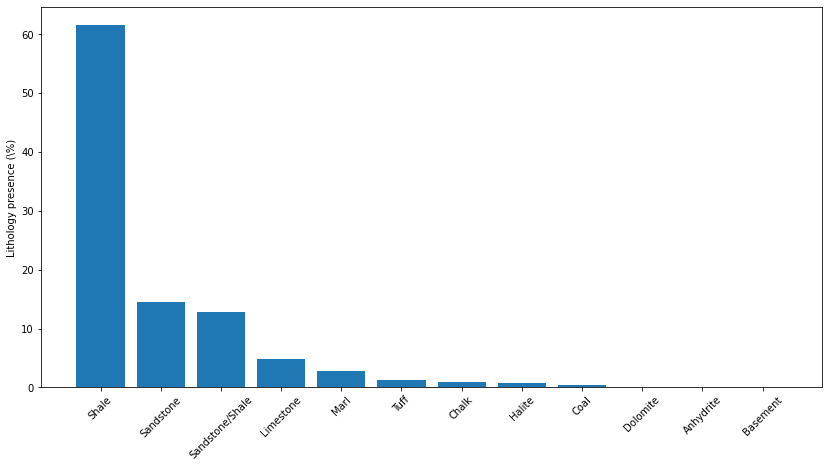

In [12]:
counts = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.iteritems():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

### Missing logs

**Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition.** The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [13]:
data.isna().any()

WELL                                 False
DEPTH_MD                             False
X_LOC                                 True
Y_LOC                                 True
Z_LOC                                 True
GROUP                                 True
FORMATION                             True
CALI                                  True
RSHA                                  True
RMED                                  True
RDEP                                  True
RHOB                                  True
GR                                   False
SGR                                   True
NPHI                                  True
PEF                                   True
DTC                                   True
SP                                    True
BS                                    True
ROP                                   True
DTS                                   True
DCAL                                  True
DRHO                                  True
MUDWEIGHT  

In [14]:
data.isna().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

The following plot shows how large a percentage of training data wells contain at least some depth interval with the given logs. As you can see a couple of logs like RT and DTS are present in less than half of the training wells. **Remember, the test data will have a similar distribution of available logs**

Text(0, 0.5, 'Well presence (\\%)')

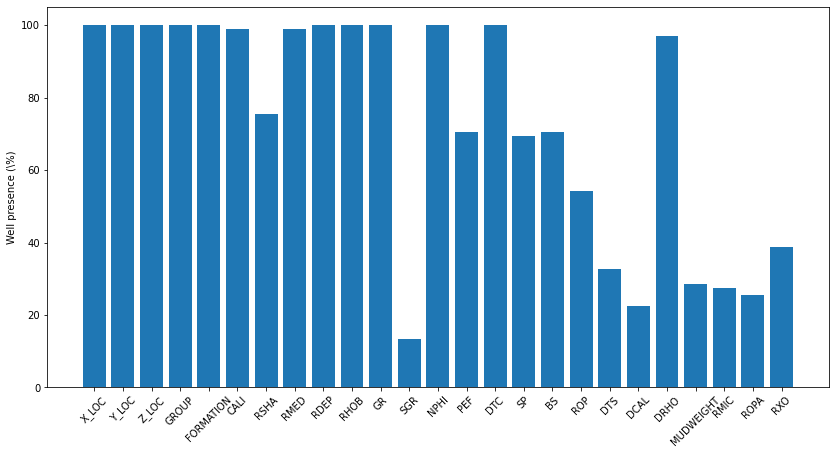

In [15]:
occurences = np.zeros(25)
for well in data['WELL'].unique():
    occurences += data[data['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(data.WELL.unique().shape[0]-occurences)/data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(data.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

In [16]:
data.WELL.unique().shape[0]

98

In [17]:
data['WELL'].unique()

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [18]:
data[data['WELL'] == '15/9-13'].isna().all().astype(int).values[2:-2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0])

In [19]:
test = data[data['WELL'] == '15/9-13'].isna().all()

In [20]:
test

WELL                                 False
DEPTH_MD                             False
X_LOC                                False
Y_LOC                                False
Z_LOC                                False
GROUP                                False
FORMATION                            False
CALI                                 False
RSHA                                 False
RMED                                 False
RDEP                                 False
RHOB                                 False
GR                                   False
SGR                                   True
NPHI                                 False
PEF                                  False
DTC                                  False
SP                                   False
BS                                    True
ROP                                  False
DTS                                   True
DCAL                                  True
DRHO                                 False
MUDWEIGHT  

In [21]:
test1 = data[data['WELL'] == '15/9-13'].isna().all().astype(int).values[2:-2]

In [22]:
test1.shape

(25,)

#### Look at some log curves for a couple of wells

(3272.0240000000003, 494.528)

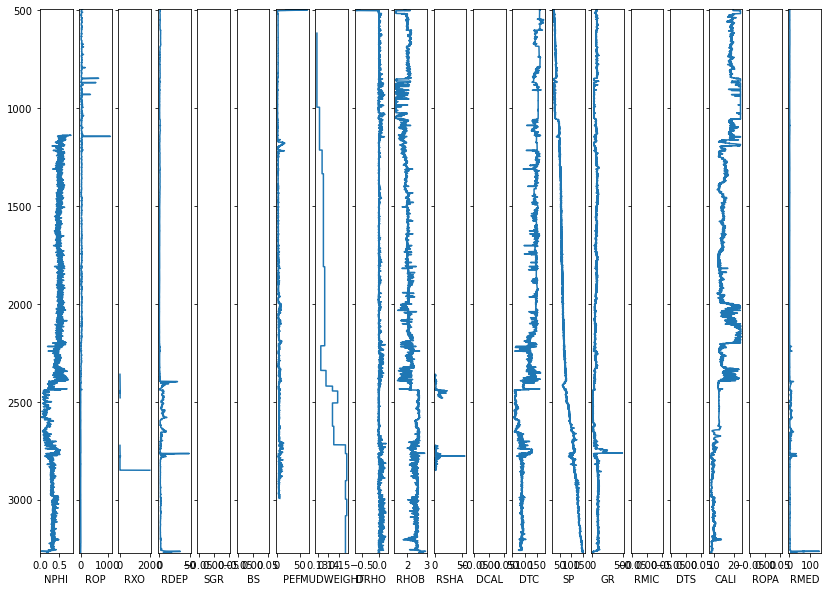

In [23]:
well_data = data[data['WELL'] == wells[0]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

(4422.0172, 2484.1692)

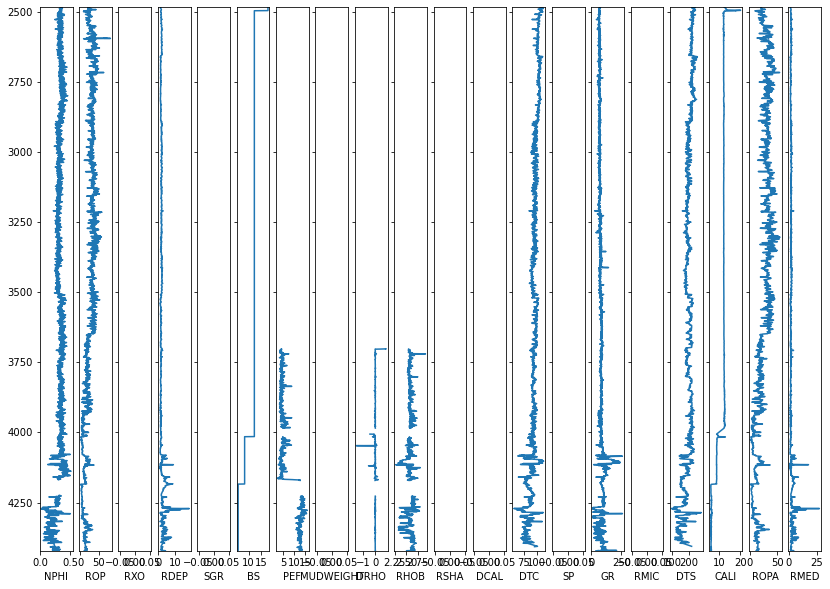

In [24]:
well_data = data[data['WELL'] == wells[57]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

### Preparing data for training

In [25]:
X = data.drop(columns=['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'])

##### As a simple approach we replace nan with zero and hope for the best

In [26]:
X.fillna(0, inplace=True)

#### We should convert lithology labels to numbers 0-11 before training

In [27]:
y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [28]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [29]:
y = y.map(lithology_numbers)

##### Lithologies are not equally likely. Probably smart to take this into account by computing class weights

In [30]:
np.bincount(y)

array([168937, 150455, 720803,  33329,   1688,  56320,  10513,   8213,
         1085,  15245,   3820,    103], dtype=int64)

##### Shuffle the data

In [31]:
X, y = shuffle(X, y, random_state=42)

In [32]:
X

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
30423,2343.304000,436806.46875,6463010.5,-2318.007324,ROGALAND GP.,Lista Fm.,14.882113,0.771240,0.771240,0.662699,...,88.208725,12.250001,12.761565,0.000000,2.632109,0.115312,0.143792,0.000000,0.000000,0.57085
1073159,3582.467851,543919.75000,6856653.5,-3477.858154,CROMER KNOLL GP.,Roedby Fm.,8.645628,0.000000,5.599961,4.988578,...,0.000000,8.500000,10.556081,150.206314,0.000000,-0.007215,0.000000,6.627153,10.410796,0.00000
436368,734.814000,483545.34375,6590313.0,-709.762207,NORDLAND GP.,Utsira Fm.,0.000000,0.000000,0.000000,1.000559,...,0.000000,17.500000,109.271744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
290688,1075.968000,487291.25000,6643945.0,-1053.937988,HORDALAND GP.,0,17.646826,0.000000,0.867609,1.231773,...,21.596836,17.500000,7.970956,0.000000,0.215513,0.051340,0.958611,0.000000,0.000000,0.00000
1118085,3580.061600,537897.75000,6791142.5,-3069.179688,BAAT GP.,Rannoch Fm.,8.572706,0.000000,7.634528,8.066478,...,0.000000,8.500000,31.773550,140.671463,0.000000,0.039784,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,2619.545201,0.00000,0.0,0.000000,ZECHSTEIN GP.,Smith Bank Fm.,12.437759,0.000000,0.000000,0.000000,...,0.000000,12.250001,2.385924,0.000000,0.000000,0.000000,1.425934,0.000000,0.000000,0.00000
259178,3032.057901,476870.34375,6625402.0,-3008.017822,VIKING GP.,Draupne Fm.,12.151999,1.934554,1.315825,1.341654,...,58.382977,12.250001,0.000000,0.000000,-0.098000,0.037645,0.000000,0.000000,0.000000,0.00000
131932,2015.638396,476768.28125,6523588.5,-1989.272949,HEGRE GP.,Skagerrak Fm.,8.527798,0.000000,1.631037,1.619809,...,0.000000,8.500000,9.060954,172.162643,0.000000,-0.001382,0.000000,0.000000,0.000000,0.00000
671155,1424.414000,530753.68750,6732068.0,-1380.430908,ROGALAND GP.,Lista Fm.,0.000000,0.000000,0.000000,0.576554,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


#### Select only the columns you want to use

In [33]:
X.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION', 'CALI',
       'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF', 'DTC', 'SP',
       'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO'],
      dtype='object')

In [34]:
X = X[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]

##### Scale the features

In [35]:
scaler = StandardScaler()

In [36]:
X.columns

Index(['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS'],
      dtype='object')

In [37]:
X = scaler.fit_transform(X)

##### Split into train and test data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Applying the custom scoring function

Apart from the missing log curves, **one of the key challenges of this machine learning competition is that you are being scored using a custom scoring function**. 

A prediction is scored using the penalty function
$$ S = - \frac{1}{N}\sum_{i=0}^N A_{ \hat{y}_i y_i} $$
where $N$ is the number of samples, $y_i$ is prediction for sample $i$, $\hat{y}_i$ is the true target for sample $i$, and $A$ is the penalty matrix given by the following

In short, the value of the matrix A at row i and column j is the **penalty** given by guessing lithology number i when the correct label is lithology numner j. Notice that the diagonal consists of zeros, no penalty is given for correct predictions.

In [39]:
A = np.load('penalty_matrix.npy')

In [40]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

The scoring function can be implemented as follows. If used as a loss function in a neural network framwork, it is recommended to implement a more efficient function based on tensor products. 

In [41]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

**IMPORTANT: The implementation above assumes zero-indexed y_true and y_pred. Be careful not to mix zero-indexed and 1-indexed class labels.**

Let us see what happens when we test the scoring function on some corner cases:

##### Lazily guessing SHALE for everything gives an OK score due to the imbalance of the dataset

In [42]:
score(y_test.values, np.ones(y_test.shape)*2)

-1.154113253567874

##### Doing the same for an uncommon class, like COAL, not so much..

In [43]:
score(y_test.values, np.ones(y_test.shape)*11)

-3.0950906225037698

##### Of course getting it completely right gives the highest possible score, 0

In [44]:
score(y_test.values, y_test.values)

0.0

### Example prediction on open test dataset

##### Train an oversimplified dummy model for the sake of the example
In order to give examples of how to submit predictions and reproducible code, we will train a RandomForestClassifier on the full feature set where we lazily have set all missing values (NaNs) to zero. This is an example only, following along this approach for the competition is not recommended. However, the template below can be used for generating predictions for the weekly leaderboard from your own model, and as an example on how to ecapsulate your model for final scoring where you have to submit code.

Apart from the inherent flaws of the random forest classifier, this example approach has a number of issues and simplifications. For example:
* Data is not separated per well. Normalization and shuffling is done across the whole dataset.
* The penatly matrix is not taken into account, it is treated as a normal classification problem.
* Missing logs are treated as zeros
* Depth and formation tops not taken into account
* Same model is used for when you only have gamma ray logs as when you have the full set of logs

In [45]:
model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')

In [46]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

In [47]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### Test model

In [48]:
y_pred_test = model.predict(X_test)

In [49]:
score(y_test.values, y_pred_test)

-0.12972655198780025

Random Forest: Accuracy=0.952
Random Forest: f1-score=0.952


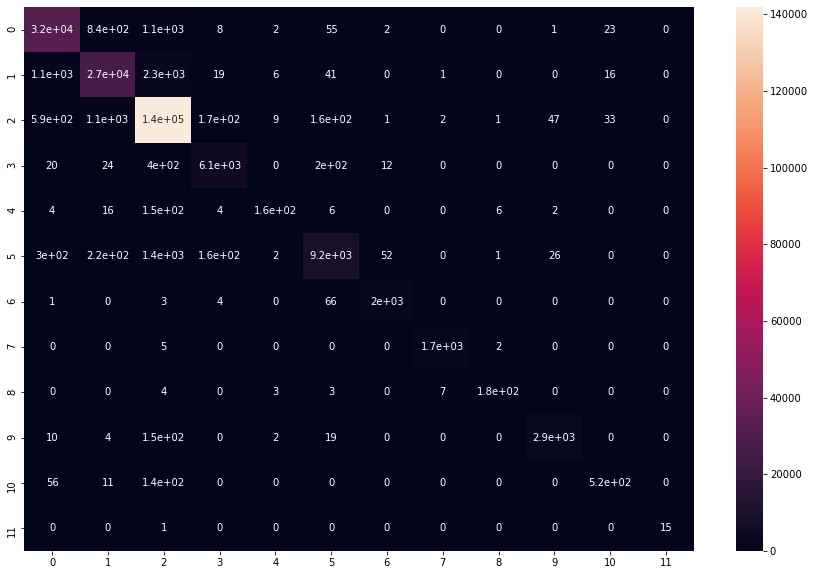

In [50]:
# check model performance using confusion matrix
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score, f1_score
ac = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted')
cm = confusion_matrix(y_test, y_pred_test)
print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))

#Plot non_normalized confustion matrix
import seaborn as sn
plt.figure(figsize = (15,10))
sn.heatmap(cm, annot=True)
plt.show()